# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.output_layer(x, activation=1)
    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Знаходимо передбачений клас
    y_pred_classes = tf.argmax(y_pred, axis=1)
    # Порівнюємо з істинними значеннями
    correct_predictions = tf.equal(y_pred_classes, tf.cast(y_true, tf.int64))
    # Обчислюємо точність
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))


In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = [neural_net.layer1.w, neural_net.layer1.b,
                               neural_net.layer2.w, neural_net.layer2.b,
                               neural_net.output_layer.w, neural_net.output_layer.b]
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)

        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())

        print(f"Step {step}, Loss: {loss.numpy():.4f}, Accuracy: {acc.numpy():.4f}")


Step 100, Loss: 311.0441, Accuracy: 0.6758
Step 200, Loss: 229.3132, Accuracy: 0.7422
Step 300, Loss: 192.9291, Accuracy: 0.7969
Step 400, Loss: 134.5784, Accuracy: 0.8438
Step 500, Loss: 131.2047, Accuracy: 0.8281
Step 600, Loss: 136.9369, Accuracy: 0.8594
Step 700, Loss: 133.8481, Accuracy: 0.8789
Step 800, Loss: 92.4982, Accuracy: 0.9062
Step 900, Loss: 129.9443, Accuracy: 0.8672
Step 1000, Loss: 88.5988, Accuracy: 0.8867
Step 1100, Loss: 90.3702, Accuracy: 0.9180
Step 1200, Loss: 96.0023, Accuracy: 0.9062
Step 1300, Loss: 90.1415, Accuracy: 0.8945
Step 1400, Loss: 83.3925, Accuracy: 0.9023
Step 1500, Loss: 78.4448, Accuracy: 0.8906
Step 1600, Loss: 61.4890, Accuracy: 0.9180
Step 1700, Loss: 124.3098, Accuracy: 0.8828
Step 1800, Loss: 90.9551, Accuracy: 0.8984
Step 1900, Loss: 68.1783, Accuracy: 0.9180
Step 2000, Loss: 75.8877, Accuracy: 0.9102
Step 2100, Loss: 50.7912, Accuracy: 0.9258
Step 2200, Loss: 62.6518, Accuracy: 0.9258
Step 2300, Loss: 87.8498, Accuracy: 0.9062
Step 2400, 

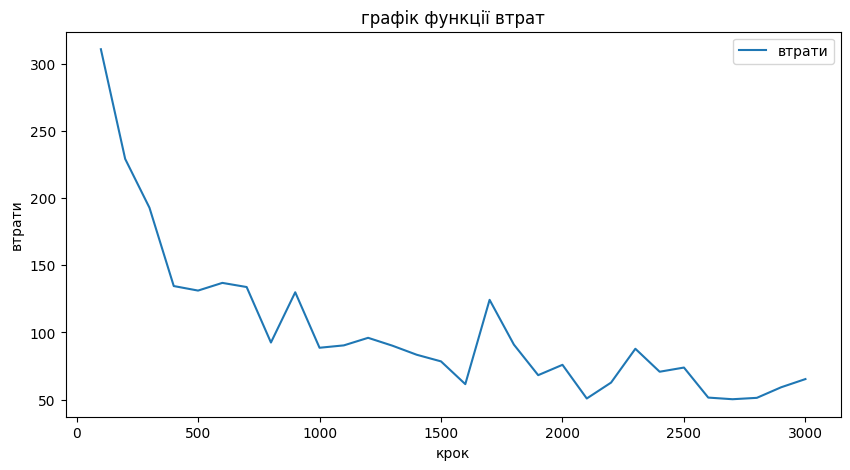

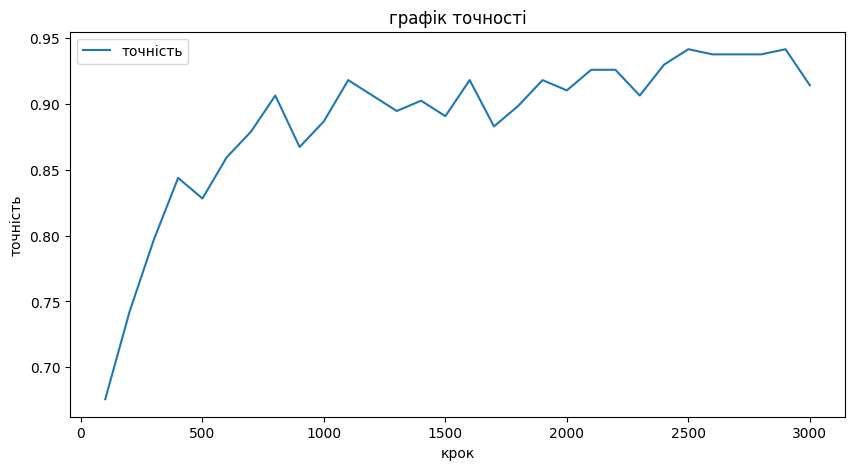

In [11]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(10, 5))
plt.plot(range(display_step, training_steps + 1, display_step), loss_history, label="втрати")
plt.xlabel("крок")
plt.ylabel("втрати")
plt.title("графік функції втрат")
plt.legend()
plt.show()

# Виведіть графік точності
plt.figure(figsize=(10, 5))
plt.plot(range(display_step, training_steps + 1, display_step), accuracy_history, label="точність")
plt.xlabel("крок")
plt.ylabel("точність")
plt.title("графік точності")
plt.legend()
plt.show()



In [14]:
# Обчисліть точність навченої нейромережі
pred_train = neural_net(x_train)
train_accuracy = accuracy(pred_train, y_train)
print(f"Точність на тренувальних даних: {train_accuracy.numpy():.4f}")

# Тестування моделі на тестових даних
pred_test = neural_net(x_test)
test_accuracy = accuracy(pred_test, y_test)
print(f"Точність на тестових даних: {test_accuracy.numpy():.4f}")

Точність на тренувальних даних: 0.9202
Точність на тестових даних: 0.9001


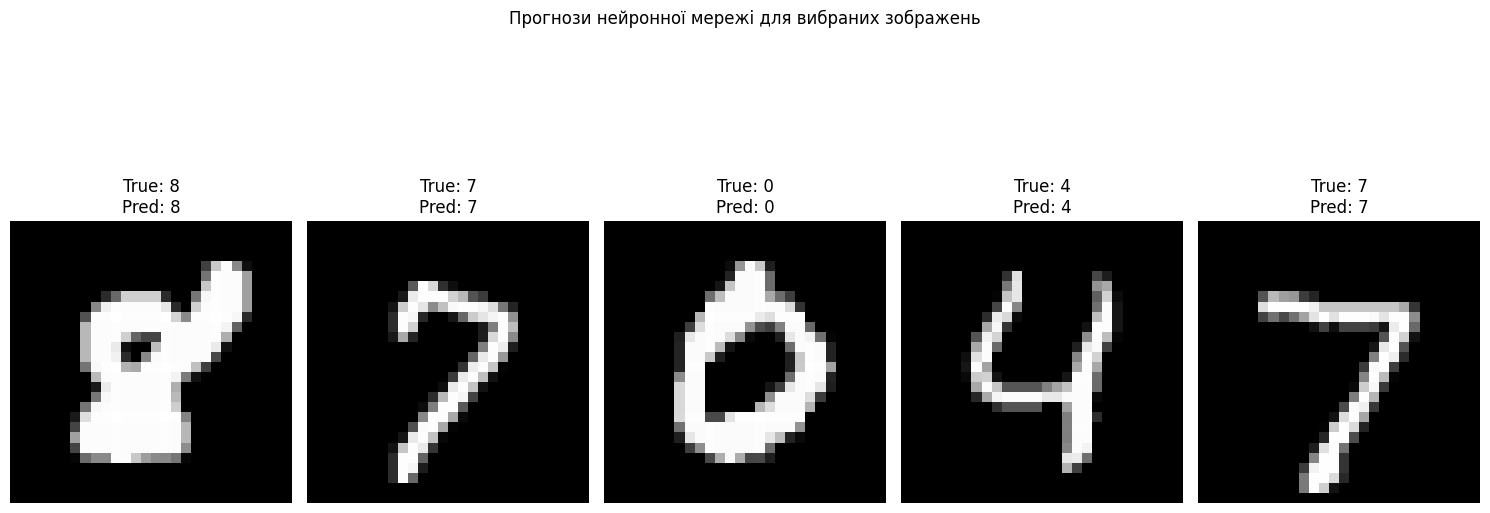

Правильних передбачень: 5 з 5


In [24]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?


import random
# вибір 10 зображень із тестової вибірки: 5 випадкових і 5 підряд
random_indices = random.sample(range(len(x_test)), 5)
sequential_indices = list(range(5))
selected_indices = random_indices + sequential_indices
selected_images = x_test[selected_indices]
selected_labels = y_test[selected_indices]

# вибір 5 випадкових зображень із цих 10
random_sample_indices = random.sample(range(len(selected_images)), 5)
sample_images = selected_images[random_sample_indices]
sample_labels = selected_labels[random_sample_indices]

# передбачення для вибраних зображень
predictions = neural_net(sample_images)
predicted_classes = tf.argmax(predictions, axis=1).numpy()


plt.figure(figsize=(15, 7))
for i, (image, true_label, pred_label) in enumerate(zip(sample_images, sample_labels, predicted_classes)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.suptitle("Прогнози нейронної мережі для вибраних зображень")
plt.tight_layout()
plt.show()

correct = sum(predicted_classes == sample_labels)
print(f"Правильних передбачень: {correct} з 5")


Метрики якості для кожного класу:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       980
           1       0.97      0.97      0.97      1135
           2       0.90      0.89      0.89      1032
           3       0.90      0.87      0.88      1010
           4       0.89      0.90      0.89       982
           5       0.78      0.91      0.84       892
           6       0.92      0.91      0.92       958
           7       0.91      0.92      0.91      1028
           8       0.88      0.85      0.86       974
           9       0.88      0.85      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


Confusion Matrix:
[[ 916    0    3    2    2   31   17    3    5    1]
 [   0 1099    5    7    0    5    3    2   12    2]
 [   6    6  919   26   14   10    9   13   24    5]
 [   2    0   24  877    2  

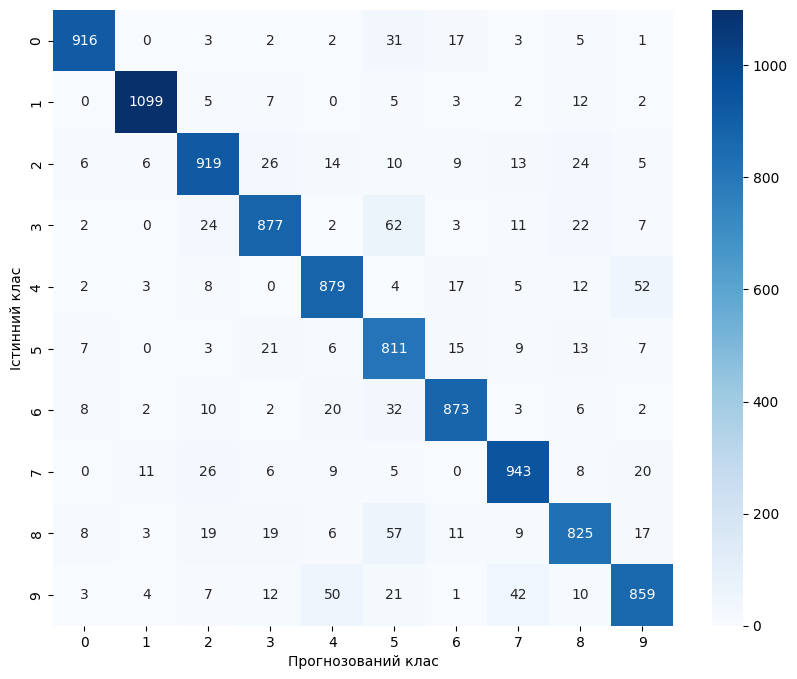

In [28]:
# Виведення метрик якості для кожного класу
from sklearn.metrics import classification_report
pred_test_classes = tf.argmax(pred_test, axis=1).numpy()
print("\nМетрики якості для кожного класу:")
print(classification_report(y_test, pred_test_classes, digits=2))


conf_matrix = confusion_matrix(y_test, pred_test_classes)

print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Прогнозований клас')
plt.ylabel('Істинний клас')
plt.show()



Висновки:
  accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


тобто точність 90%

більше всього плутає нейромережа 5, менше всього плутає 1 - рекол становить 97%